# Initialisation

In [147]:
#!pip install matplotlib
!pip install scipy

from google.colab import drive
drive.mount('/content/drive/')

#dependencies
import math 
import random
import datetime
import matplotlib
from matplotlib import figure 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm

from matplotlib.colors import LogNorm
from scipy.interpolate import interp2d

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [148]:
#@markdown #Initialisation of the population
#@markdown N = number of mortals in the simulation

#@markdown ---

N = 256 #@param {type:"slider", min:16, max:16384, step:16}
I = 8192 #@param {type:"slider", min:16, max:16384, step:16}
#@markdown ---
C = 0.02 #@param {type:"slider", min:0, max:1, step:0.005}
#F = 1 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown ---
maxEfficiency = 40 #@param {type:"slider", min:1, max:50, step:1}
mutationMagnitude = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
seasonLength = 32 #@param {type:"slider", min:1, max:256, step:1}
childCost = 30 #@param {type:"slider", min:0, max:30, step:0.1}
killCost = 0.1 #@param {type:"slider", min:0, max:5, step:0.01}
startingWorkers = 1 #@param {type:"slider", min:0, max:32, step:1}
startingStealth = 0 #@param {type:"slider", min:0, max:1, step:0.01}
totalFood = 256 #@param {type:"slider", min:0, max:8192, step:16}
queenWeight = 30 #@param {type:"slider", min:0, max:32, step:1}
splitThreshold = 4 #@param {type:"slider", min:0, max:128, step:2}
foodReserves = 0.4 #@param {type:"slider", min:0, max:1, step:0.01}
useUniform = True #@param {type:"boolean"}

class Ant:
  def __init__(self, _isAltruistic, _stealth, _dateOfBirth):
    self.stealth = _stealth
    self.isAltruistic = _isAltruistic
    self.dateOfBirth = _dateOfBirth
    self.saturation = 0

#colony class for keeping track of groups of ants
class Colony:
  def __init__(self, _isAltruistic, _saturation):
    self.saturation = _saturation
    self.workers = []
    for i in range(startingWorkers):
      self.workers.append(Ant(_isAltruistic, 0, 0))

    self.queens = []
    self.queens.append(Ant(_isAltruistic, random.random(), 0))
    self.isAltruistic = _isAltruistic
    self.foodCoefficient = 0
  
  def addWorkers(self, n):
    for i in range(n):
      self.workers = np.append(self.workers, Ant(self.isAltruistic, 0, iteration))


#ant class for every ant


#class queen: #What, they're just the same!? Certainly
#  def __init__(self, _isAltruistic, _stealth, _dateOfBirth):
#    self.isAltruistic = _isAltruistic
#    self.stealth = _stealth
#    self.dateOfBirth = _dateOfBirth

iterations = [] #iterations array for the x-axis of the graph
population = []

isAltruisticData = []
isNonAltruisticData = []
altruisticColonies = []
nonAltruisticColonies = []

#deltaPData = []
#hungerToFoodData = []


for n in range(N):
  population.append(Colony(n <= (N / 2), 10))

population = np.array(population)

# Simulation

In [149]:
newPopulation = []
def iterate():
  global newPopulation
  global population
  totalFoodCoefficient = 1
  altruistCount = 0
  nonAltruistCount = 0
  altruistCCount = 0
  nonAltruistCCount = 0
  newPopulation = np.copy(population)

  #addWorkers()
  for n, colony in reversed(list(enumerate(population))):
    colony.saturation -= C * (queenWeight * len(colony.queens) + len(colony.workers))
    if colony.saturation <= 0:
      #newPopulation = np.delete(newPopulation, n)
      for i in range(min(len(colony.workers), math.ceil(-colony.saturation / C))) :
        colony.workers = np.delete(colony.workers, 0)
        if len(colony.workers) == 0:
          colony.queens = np.delete(colony.queens, 0)
          if len(colony.queens) == 0:
            newPopulation = np.delete(newPopulation, n)
    
    foodCoefficient = 0
    if colony.isAltruistic:
      altruistCCount += 1
    else:
      nonAltruistCCount += 1
    
    for queen in colony.queens:
      if queen.isAltruistic:
        altruistCount += 1
      else:
        nonAltruistCount += 1
    for worker in colony.workers:
      foodCoefficient += abs(min(iteration - worker.dateOfBirth, maxEfficiency))+1
      
      if worker.isAltruistic:
        altruistCount += 1
      else:
        nonAltruistCount += 1
    foodCoefficient *= random.uniform(0.5, 2.0)
    totalFoodCoefficient += foodCoefficient
    colony.foodCoefficient = foodCoefficient
  for n, colony in enumerate(population):
    colony.saturation += abs((colony.foodCoefficient / totalFoodCoefficient) * totalFood)

  if iteration % seasonLength == 0 and iteration != 0:
    addWorkers()
    reproduce()
    splitAltruists()
  isAltruisticData.append(altruistCount)
  isNonAltruisticData.append(nonAltruistCount)
  altruisticColonies.append(altruistCCount)
  nonAltruisticColonies.append(nonAltruistCCount)
  population =  np.copy(newPopulation)

def reproduce():
  global newPopulation
  global population
  newPopulation = population
  bourgeoisie = []
  for n, colony in enumerate(population):
    for i, queen in enumerate(population[n].queens):
      queen.saturation = colony.saturation / len(colony.queens)
      bourgeoisie.append(queen)
  for n, colony in enumerate(population):
    for i, queen in enumerate(population[n].queens):
      if queen.saturation > 0:
        for j in np.random.choice(bourgeoisie, int((1 - foodReserves) * queen.saturation / childCost)):
          colony.saturation -= childCost
          offspring = mate(queen, j)
          if offspring != 0:
            if (not offspring.isAltruistic) and colony.isAltruistic: #is an imposter?
              if random.uniform(0, 1) <= offspring.stealth: #starts own colony
                colony.saturation *= (1 - 0.05)
                newColony = Colony(False, 0.05 * colony.saturation)
                newColony.queens = [offspring]
                newPopulation = np.append(newPopulation, newColony)
              else: #kill imposter
                colony.saturation = colony.saturation - killCost
            else:
              colony.queens.append(offspring)
            #else:
            #  colony.workers.append(offspring)

def mate(parent1, parent2):
  isAltruistic = False
  isLethal = False
  if (not parent1.isAltruistic and not parent2.isAltruistic):
    isAltruistic = False
  elif (parent1.isAltruistic and parent2.isAltruistic):
    isAltruistic = random.random() <= 1/3
    isLethal = random.random() <= 1/4
  else:
    isAltruistic = random.random() <= 1/2
  if not isLethal:
    if useUniform: 
      output = Ant(isAltruistic, max(min(0.5*parent1.stealth + 0.5*parent2.stealth + mutationMagnitude * random.uniform(0, 1), 1), 0), iteration)
    else:
      output = Ant(isAltruistic, max(min(0.5*parent1.stealth + 0.5*parent2.stealth + mutationMagnitude * random.randrange(0, 1), 1), 0), iteration)
    output.dateOfBirth = iteration
    return output
  else:
    return 0

def addWorkers():
  global iteration
  for colony in population:
    colony.addWorkers(len(colony.queens) * 10)

def newWorker(colony):
  global iteration
  colony.workers = np.append(colony.workers, Ant(colony.isAltruistic, 0, iteration))

def splitAltruists():
  global population
  newColonies = []
  for n, colony in reversed(list(enumerate(population))):
    if colony.isAltruistic == True and colony.saturation >= splitThreshold and len(colony.queens) >= 2:
      random.shuffle(colony.workers)

      newColony = Colony(True, colony.saturation / 2)
      newColony.workers = colony.workers[0:math.floor(len(colony.workers)/2)-1]
      newColony.queens = [colony.queens[0]]
      newColonies.append(newColony)

      oldColony = Colony(True, colony.saturation / 2)
      oldColony.workers = colony.workers[math.floor(len(colony.workers)/2):]
      oldColony.queens = [colony.queens[1]]
      newColonies.append(oldColony)

      population = np.delete(population, n)
  np.append(population, newColonies)

foodReservesArray = [0.2, 0.4, 0.6, 0.8, 0.2, 0.4, 0.6, 0.8, 0.2, 0.4, 0.6, 0.8, 0.2, 0.4, 0.6, 0.8]
splitThresholdArray = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
survivalProbability = []

def run():
  global iteration
  global isAltruisticData
  global isNonAltruisticData
  global population
  
  population = []
  for n in range(N):
    population.append(Colony(n <= (N / 2), 10))
  population = np.array(population)

  isAltruisticData = []
  isNonAltruisticData = []

  iteration = 0
  for i in range(0, I - 1): # tqdm makes a fancy progressbar
    iteration = i
    iterate()

  isAltruisticPercentageData = []
  isNonAltruisticPercentageData = []
  for i in range(len(isAltruisticData)):
    if isAltruisticData[i] + isNonAltruisticData[i] > 0:
      isAltruisticPercentageData.append(isAltruisticData[i] / (isAltruisticData[i] + isNonAltruisticData[i]))
      isNonAltruisticPercentageData.append(isNonAltruisticData[i] / (isAltruisticData[i] + isNonAltruisticData[i]))
    else:
      isAltruisticPercentageData.append(0)
      isNonAltruisticPercentageData.append(0)

  return isAltruisticPercentageData[len(isAltruisticPercentageData) - 1]

for r in tqdm(range(len(foodReservesArray))):
  #global foodReserves
  #global splitThreshold
  foodReserves = foodReservesArray[r]
  splitThreshold = splitThresholdArray[r]
  a = run()
  survivalProbability.append(a)


100%|██████████| 16/16 [21:48<00:00, 81.75s/it]


# Visualisation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


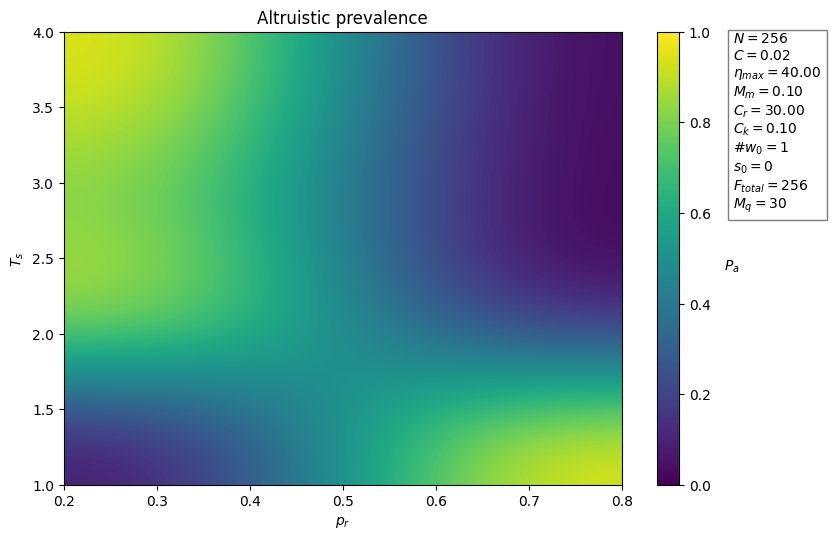

In [158]:
def formatPlot():
  plt.rcParams['figure.dpi'] = 100
  plt.rcParams["figure.figsize"] = (8,6)

palette = ['#1bdb18', '#13b6c1']
props = dict(facecolor='white', alpha=0.5)

#survivalProbability = [0, 0, 0.3, 0.5, 0, 0, 0.3, 0.3, 0.6, 0.7, 0.0, 0.5, 0.6, 0.8, 0.4, 0.2]



def visualiseData():
  formatPlot()
  
  textstr = textstr = '\n'.join((
    r'$N =%i$' % (N, ),
    r'$C =%.2f$' % (C, ),
    r'$\eta_{max} =%.2f$' % (maxEfficiency, ),
    r'$M_m =%.2f$' % (mutationMagnitude, ),
    r'$C_r =%.2f$' % (childCost, ),
    r'$C_k =%.2f$' % (killCost, ),
    r'$\# w_0 =%i$' % (startingWorkers, ),
    r'$s_0 =%i$' % (startingStealth, ),
    r'$F_{total} =%i$' % (totalFood, ),
    r'$M_q =%i$' % (queenWeight, )))

  x_list = np.array(foodReservesArray)
  z_list = np.array(splitThresholdArray)
  C_I_list = np.array(survivalProbability)
  f = interp2d(x_list, z_list, C_I_list, kind="linear")

  x_coords = np.arange(min(x_list),max(x_list)+1)
  z_coords = np.arange(min(z_list),max(z_list)+1)
  c_i = f(x_coords,z_coords)

  plt.figure(figsize=(9,6))
  fig = plt.imshow(c_i, extent=[min(x_list),max(x_list),min(z_list),max(z_list)], origin="lower", interpolation='bicubic', aspect='auto')

  # Show the positions of the sample points, just to have some reference
  fig.axes.set_autoscale_on(False)
  plt.scatter(x_list,z_list,400,facecolors='none')
  
  plt.title('Altruistic prevalence')
  plt.xlabel('$p_r$')
  plt.ylabel('$T_s$')
  cbar = plt.colorbar()
  cbar.ax.get_yaxis().labelpad = 15
  cbar.set_label('$P_a$', rotation=0)
  ax = plt.axes()
  ax.text(1.2, 1, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)

  plt.savefig(f"/content/drive/My Drive/Profielwerkstuk/Output/plot9@{datetime.datetime.now()}.png", bbox_inches='tight', dpi=400)
  plt.show()

visualiseData()